In [ ]:
!pip install gym 
!wget http://www.atarimania.com/roms/Roms.rar
!unrar x /content/Roms.rar
!unzip /content/ROMS.zip
!pip install gym-retro
!python3 -m retro.import ROMS/
!apt-get install -y xvfb x11-utils
!pip install gym[all]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install pyvirtualdisplay

In [3]:
import retro 
import random
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import numpy as np
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

In [5]:
seed = 42
gamma = 0.90
epsilon = 1.0
epsilon_min = 0.1 
epsilon_max = 1.0 

epsilon_interval = (
    epsilon_max - epsilon_min
)

batch_size = 32 
max_steps_per_episode = 1000

env = retro.make(game="SpaceInvaders-Atari2600")
env.seed(seed)

[42, 742738649]

In [6]:
num_actions = env.action_space.n

def q_model():
  input = layers.Input(shape=(84, 84, 4))

  # Convolutions on the frames 
  layer_1 = layers.Conv2D(32, 8, strides=4,
                          activation="relu")(inputs)
  layer_2 = layers.Conv2D(64, 4, strides=2,
                          activation="relu")(layer1)
  layer_3 = layers.Conv2D(64, 3, strides=1,
                          activation="relu")(layer2)

  layer_4 = layers.Flatten()(layer_3)

  layer_5 = layers.Dense(512, activation="relu")(layer_4)

  action = layers.Dense(num_actions, outputs="linear")(layer_5)

  return keras.Model(inputs=inputs, outputs=action)

  # Make a action
  model = q_model()

  # Build a target model for estimate future rewrds
  model_target = q_model()

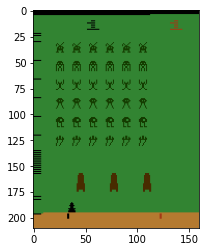

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []

runnung_reward = 0
episode_count = 0
frame_count = 0

epsilon_random_frames = 50000
epsilon_greedy_frames = 1000000.0 
max_memory_length = 100000

update_after_actions = 4
update_target_network = 10000

loss = keras.losses.Huber()

display = Display(visible=False, size=(600, 500))
display.start()

height, width, channels = env.observation_space.shape
actions = env.action_space.n
episodes = 5
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [15]:
while True:
  state = np.array(env.reset())
  episode_reward = 0

  env.render(mode='rgb_array')
  screen = env.render(mode='rgb_array')

  for timestep in range(1, max_steps_per_episode):
    frame_count += 1

    if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
      action = np.random.choice(num_actions)

    else:
      state_tensor = tf.convert_to_tensor(state)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = model(state_tensor, training=False)

      # Take Best Action
      action = tf.argmax(action_probs[0]).numpy()

    # Decay probabilty of taking random action 
    epsilon -= epsilon_interval / epsilon_greedy_frames
    epsilon = max(epsilon, epsilon_min)

    # Apply sample action 
    state_next, reward, done, _ = env.step(action))
    state_next = np.array(state_next)

    episode_reward += reward 

    # Save action, states in replay buffer 
    action_history.append(action)
    state_history.append(state)
    state_next_history.append(state_next)
    done_history.append(done)
    rewards_history.append(reward)

    state = state_next

    # Update every 4th frame and once batch size >= 32 
    if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
      indices = np.random.choice(range(len(done_history)), size=batch_size)

      state_sample = np.array([state_history[i] for i in indices])
      state_next_sample = np.array([state_next_history[i] for i in indices])
      reward_sample = [rewards_history[i] for i in indices]
      action_sample = [action_history[i] for i in indices]

      done_sample = tf.convert_to_tensor(
          [float(done_history[i] for i in indices)]
      )

      # Build the updated Q-values for the sampled future states
      future_reward = model_target.predict(state_next_sample)

      update_q_values = reward_sample + gamma * tf.reduce_max(future_reward, axis=1)

      updare_q_values = updated_q_values * (1 - done_sample) - done_sample

      masks = tf.one_hot(action_sample, num_actions)

      with tf.GradientTape() as tape:
        # Train model on the states and updated Q-values
        q_values = model(state_sample)

        # Apply the masks to the q-values to get Q-value for action
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

        q_loss = loss_function(updated_q_values, q_action)

      # Backpropagation 
      grads = tape.gradient(q_loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if frame_count % update_target_network == 0:
      model_target.set_weights(model.get_weights())

      template = "running reward: {:.2f} / episode {}, frame count {}"
      print(template.format(running_reward, episode_count, frame_count))

    # Limit the state and reward history
    if len(rewards_history) > max_memory_length:
      del rewards_history[:1]
      del state_history[:1]
      del state_next_history[:1]
      del action_history[:1]
      del done_history[:1]

    if done:
      break

  # Update runnung reward to check condition for solving 
  episode_reward_history.append(episode_reward)

  if len(episode_reward_history) > 100:
    del episode_reward_history[:1]

  runnung_reward = np.mean(episode_reward_history)

  episode_count += 1

  if running_reward > 40:
    print("Finished at episode {}".format(episode_count))
    break

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
      
ipythondisplay.clear_output(wait=True)
env.close()

TypeError: ignored